# Train model

In [1]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column
import tensorflow as tf

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import random
import os

%load_ext autoreload
%autoreload 2


In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)


tf.keras.backend.set_floatx('float32')

In [3]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [4]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot
    return r2

In [5]:
train = preprocessing_fn(
    data='data/train.csv',
    norm_params='data/numerical_features_normalization.csv',
    model_clusters='data/model_clusters.csv'
)
val = preprocessing_fn(
    data='data/val.csv',
    norm_params='data/numerical_features_normalization.csv',
    model_clusters='data/model_clusters.csv',
)
test = preprocessing_fn(
    data='data/test.csv',
    norm_params='data/numerical_features_normalization.csv',
    model_clusters='data/model_clusters.csv'
)

train = train.dropna()
val = val.dropna()
test = test.dropna()

print(train.shape)
print(val.shape)
print(test.shape)

(85967, 11)
(21492, 11)
(46055, 11)


In [6]:
train.dtypes

price                   int32
abtest                 object
vehicleType            object
yearOfRegistration    float32
gearbox                object
powerPS               float32
kilometer             float32
fuelType               object
brand                  object
notRepairedDamage      object
cluster_model           int32
dtype: object

In [7]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=512)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=512)
test_ds = df_to_dataset(dataframe=test, target_name='price', shuffle=True, batch_size=512)

In [8]:
from cars_model import getModel
%reload_ext autoreload
%autoreload 2

model = getModel(data=train, dp_rate=0.05, hu=60)

Epoch 1/100
168/168 [==============================] - 2s 10ms/step - loss: 2843.4595 - mean_squared_error: 26546572.0000 - val_loss: 1723.9893 - val_mean_squared_error: 20765058.0000
Epoch 2/100
168/168 [==============================] - 1s 8ms/step - loss: 1554.8394 - mean_squared_error: 22001528.0000 - val_loss: 1456.3960 - val_mean_squared_error: 30260300.0000
Epoch 3/100
168/168 [==============================] - 1s 8ms/step - loss: 1332.8561 - mean_squared_error: 17854168.0000 - val_loss: 1229.9945 - val_mean_squared_error: 9120503.0000
Epoch 4/100
168/168 [==============================] - 1s 8ms/step - loss: 1162.7432 - mean_squared_error: 6101482.5000 - val_loss: 1128.9214 - val_mean_squared_error: 4934272.5000
Epoch 5/100
168/168 [==============================] - 1s 8ms/step - loss: 1108.6383 - mean_squared_error: 4664974.0000 - val_loss: 1097.3462 - val_mean_squared_error: 4643405.5000
Epoch 6/100
168/168 [==============================] - 1s 8ms/step - loss: 1086.8967 - me

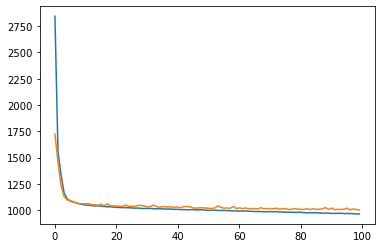

In [9]:
# Compile Keras model
lr = 0.001
model.compile(
    loss='mean_absolute_error',
    metrics=['mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr))

# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

# get results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.loss)
plt.plot(hist.epoch, hist.val_loss)
plt.show()

In [10]:
tf.keras.models.save_model(model, "cars_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cars_model\assets


In [11]:
# model = tf.keras.models.load_model("cars_model")

# a = df_to_dataset(dataframe=val, target_name='price', shuffle=False, batch_size=1000)

# preds = model.predict(a)

In [12]:
# a = df_to_dataset(dataframe=val, target_name='price', shuffle=False, batch_size=1000)

# preds = model.predict(a)

In [13]:
# Validation results
print('VALIDATION RESULTS\n')
val_pred = model.predict(df_to_dataset(dataframe=val, target_name='price', shuffle=False, batch_size=1000)).flatten()

val['price_pred'] = val_pred
val['abs_error'] = abs(val.price_pred - val.price)
val['error'] = val.price_pred - val.price

# super baseline model
print('baseline abs error: ' + str(np.mean(np.abs(val.price - train.price.mean()))))

# my model
print('model abs error: ' + str(np.mean(np.abs(val.price - val_pred))))

# r squared
print('model r2: ' + str(r2_score(val.price, val.price_pred)))

VALIDATION RESULTS

baseline abs error: 3577.8200608494003
model abs error: 1002.0115185831149
model r2: 0.8579217531122396


In [14]:
# Test results
print('TEST RESULTS\n')
test_pred = model.predict(df_to_dataset(dataframe=test, target_name='price', shuffle=False, batch_size=1000)).flatten()

test['price_pred'] = test_pred
test['abs_error'] = abs(test.price_pred - test.price)
test['error'] = test.price_pred - test.price

worst_predictions = test.copy().loc[test.abs_error >= test.abs_error.quantile(0.9)]

# super baseline model
print('baseline abs error: ' + str(np.mean(np.abs(test.price - train.price.mean()))))

# my model
print('model abs error: ' + str(np.mean(np.abs(test.price - test_pred))))

# r squared
print('model r2: ' + str(r2_score(test.price, test.price_pred)))

TEST RESULTS

baseline abs error: 3546.091120027012
model abs error: 987.0471645078161
model r2: 0.8585800742143339


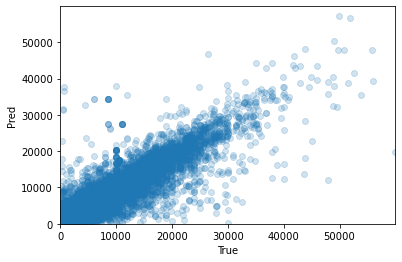

In [15]:
plt.scatter(test.price, test_pred, alpha=0.2)
plt.xlim([0, test.price.max()])
plt.ylim([0, test.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

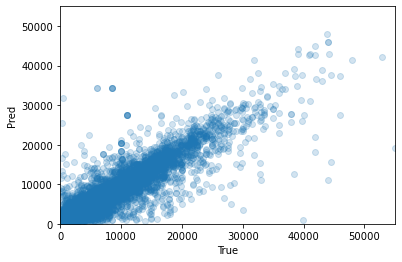

In [16]:
plt.scatter(val.price, val_pred, alpha=0.2)
plt.xlim([0, val.price.max()])
plt.ylim([0, val.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

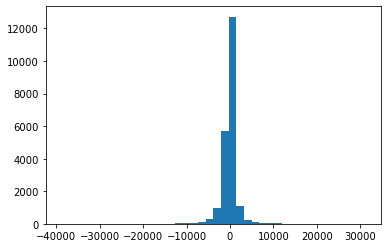

In [17]:
plt.hist(val.error, bins=40)
plt.show()

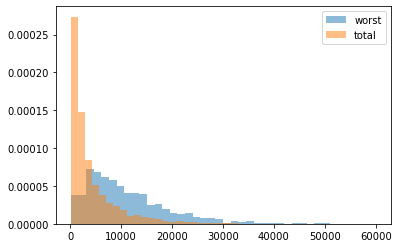

In [18]:
plt.hist(worst_predictions.price, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(val.price, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

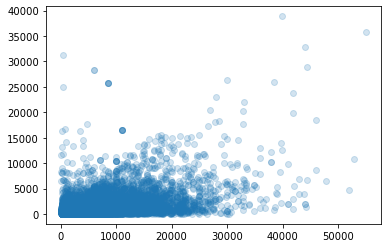

In [19]:
plt.scatter(val.price, val.abs_error, alpha=0.2)
plt.show()

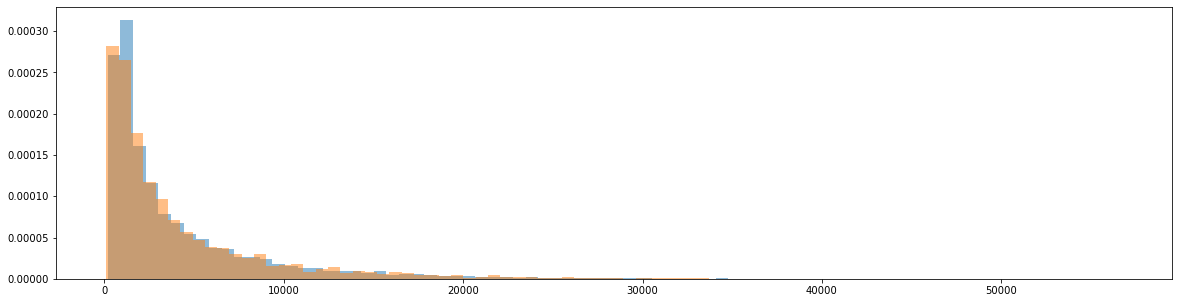

In [20]:
plt.figure(figsize=(20,5))
plt.hist(val.price_pred, bins=80, alpha=0.5, density=True)
plt.hist(val.price, bins=80, alpha=0.5, density=True)
plt.show()

In [21]:
test.price.max()

59900

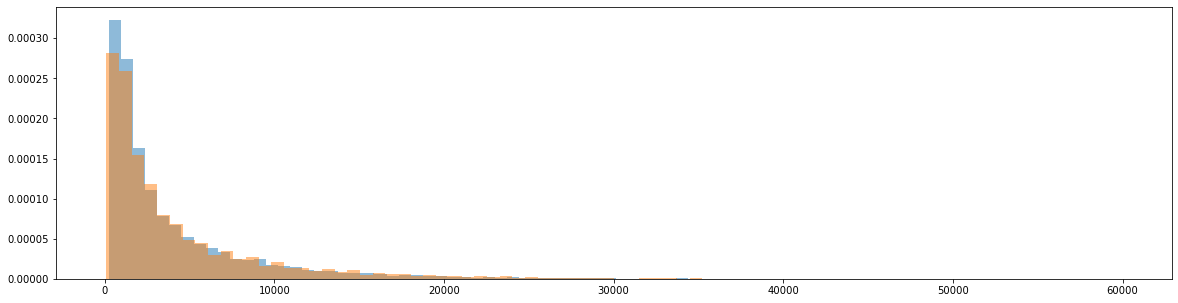

In [22]:
plt.figure(figsize=(20,5))
plt.hist(test.price_pred, bins=80, alpha=0.5, density=True)
plt.hist(test.price, bins=80, alpha=0.5, density=True)
plt.show()